# Example of TSPR Testing Cases

## Initalization

In [1]:
# Import auxiliary packages
import matplotlib.pyplot as plt
import json, six, glob, os

os.chdir('../../src')

# Import ANIMATE
from workflowsteps import *
from library import *
from libcases import *
from datetimeep import DateTimeEP

In [2]:
# Create test cases
test_case_list = {
    'sat_reset': 'SupplyAirTempReset',
    'chw_reset': 'CHWReset'
}
cases = {}
cases['cases'] = []
case_counter = 0

## SAT Reset

In [3]:
# Create cases "on-the-fly"
for idf in glob.glob('../resources/tspr_cases/sat_reset/*.idf'):
    if not "injected" in idf:
        sat_case = {}
        sat_case["no"] = str(case_counter)

        idf_json = json.load(open(idf.replace(".idf", ".epJSON")))

        # Retrieve supply inlet node name of first airloop
        airloops = idf_json["AirLoopHVAC"]
        airloop = list(airloops.keys())[0]
        sat_node = airloops[airloop]["supply_side_outlet_node_names"]
        if sat_node in idf_json["NodeList"]:
            sat_node = idf_json["NodeList"][sat_node]["nodes"][0]["node_name"]

        # Retrieve zone design cooling temperature
        schs = idf_json["Schedule:Day:Interval"]
        sch = [s for s in list(schs.keys()) if "_Cooling_Schedule_Summer_Design_Day" in s][0]
        tz_coo = 99
        for d in schs[sch]["data"]:
            if d["value_until_time"] < tz_coo:
                tz_coo = d["value_until_time"]

        # Define simulation IO
        sat_case["run_simulation"] = True
        sat_case["simulation_IO"] = {
            "idf": "../resources/tspr_cases/sat_reset/{}".format(idf.split('\\')[-1]),
            "idd": "../resources/Energy+V9_2_0.idd",
            "weather": "../weather/USA_WA_Seattle-Tacoma.Intl.AP.727930_TMY3.epw",
            "output": "eplusout.csv",
            "ep_path": "C:\EnergyPlusV9-2-0\energyplus.exe"
        }
        sat_case["expected_result"] = "pass"
        sat_case["verification_class"] = test_case_list["sat_reset"]
        sat_case["datapoints_source"] = {
            "idf_output_variables": {
                "T_sa_set": {
                    "subject": f"{sat_node}",
                    "variable": "System Node Setpoint Temperature",
                    "frequency": "detailed"
                }
            },
            "parameters": {
                "T_z_coo": tz_coo
            }
        }
        cases['cases'].append(sat_case)
        case_counter += 1
json.dump(cases, open('../resources/tspr_cases/tspr_verification_cases.json', 'w'), indent=4)

## CHW Reset

In [4]:
# Create cases "on-the-fly"
for idf in glob.glob('../resources/tspr_cases/chw_reset/*.idf'):
    if not "injected" in idf:
        chw_case = {}
        chw_case["no"] = str(case_counter)

        idf_json = json.load(open(idf.replace(".idf", ".epJSON")))

        # Retrieve supply inlet node name of first airloop
        plantloops = idf_json["PlantLoop"]
        chloop = [p for p in plantloops if "chiller" in p.lower()][0]
        chw_node = plantloops[chloop]["loop_temperature_setpoint_node_name"]

        # Get chiller name
        chillers = idf_json["Chiller:Electric:EIR"]
        chiller = list(chillers.keys())[0]

        # Retrieve zone design cooling temperature
        spm_rt_oa = idf_json["SetpointManager:OutdoorAirReset"]
        for s, v in spm_rt_oa.items():
            if chw_node in v['setpoint_node_or_nodelist_name']:
                t_oa_max = v['outdoor_high_temperature']
                t_oa_min = v['outdoor_low_temperature']
                t_chw_max_st = v['setpoint_at_outdoor_low_temperature']
                t_chw_min_st = v['setpoint_at_outdoor_high_temperature']

        # Define simulation IO
        chw_case["run_simulation"] = True
        chw_case["simulation_IO"] = {
            "idf": "../resources/tspr_cases/chw_reset/{}".format(idf.split('\\')[-1]),
            "idd": "../resources/Energy+V9_2_0.idd",
            "weather": "../weather/USA_WA_Seattle-Tacoma.Intl.AP.727930_TMY3.epw",
            "output": "eplusout.csv",
            "ep_path": "C:\EnergyPlusV9-2-0\energyplus.exe"
        }
        chw_case["expected_result"] = "pass"
        chw_case["verification_class"] = test_case_list["chw_reset"]
        chw_case["datapoints_source"] = {
            "idf_output_variables": {
                "T_oa_db": {
                    "subject": "Environment",
                    "variable": "Site Outdoor Air Drybulb Temperature",
                    "frequency": "TimeStep"
                },
                "T_chw": {
                    "subject": f"{chw_node}",
                    "variable": "System Node Setpoint Temperature",
                    "frequency": "TimeStep"
                },
                "m_chw": {
                    "subject": f"{chiller}",
                    "variable": "Chiller Evaporator Mass Flow Rate",
                    "frequency": "TimeStep"
                }
            },
            "parameters": {
                "T_oa_max": t_oa_max,
                "T_oa_min": t_oa_min,
                "T_chw_max_st": t_chw_max_st,
                "T_chw_min_st": t_chw_min_st
            }
        }
        cases['cases'].append(chw_case)
        case_counter += 1
json.dump(cases, open('../resources/tspr_cases/tspr_verification_cases.json', 'w'), indent=4)

In [5]:
len(cases['cases'])

3

idf_output_variables
{'T_sa_set': {'subject': 'Node 85', 'variable': 'System Node Setpoint Temperature', 'frequency': 'detailed'}}
parameters
{'T_z_coo': 24}
Running case - SupplyAirTempReset
Running simulation: ../resources/tspr_cases/sat_reset/sat_reset_injected.idf -- 2021-09-24 10:26:52.672256
Simulation complete -- 2021-09-24 10:29:26.940805
Simulation log saved to output folder -- 2021-09-24 10:29:26.947810
simulation done
Verification results dict: 
{'Sample #': 47472, 'Pass #': 47472, 'Fail #': 0}
Specific plot method implemented, additional distribution plot is being added!


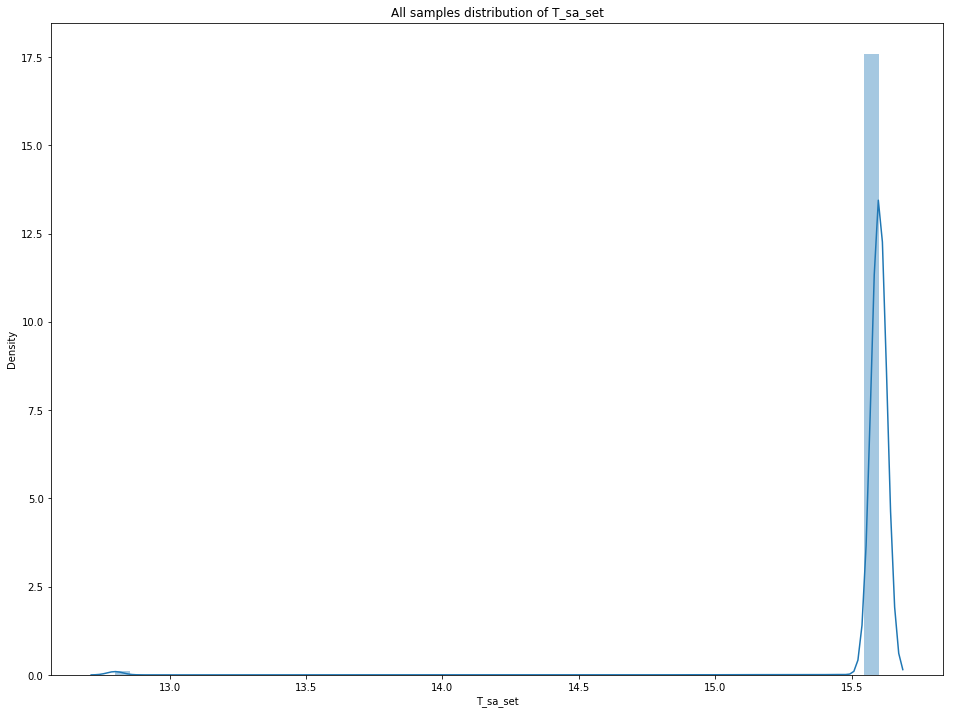

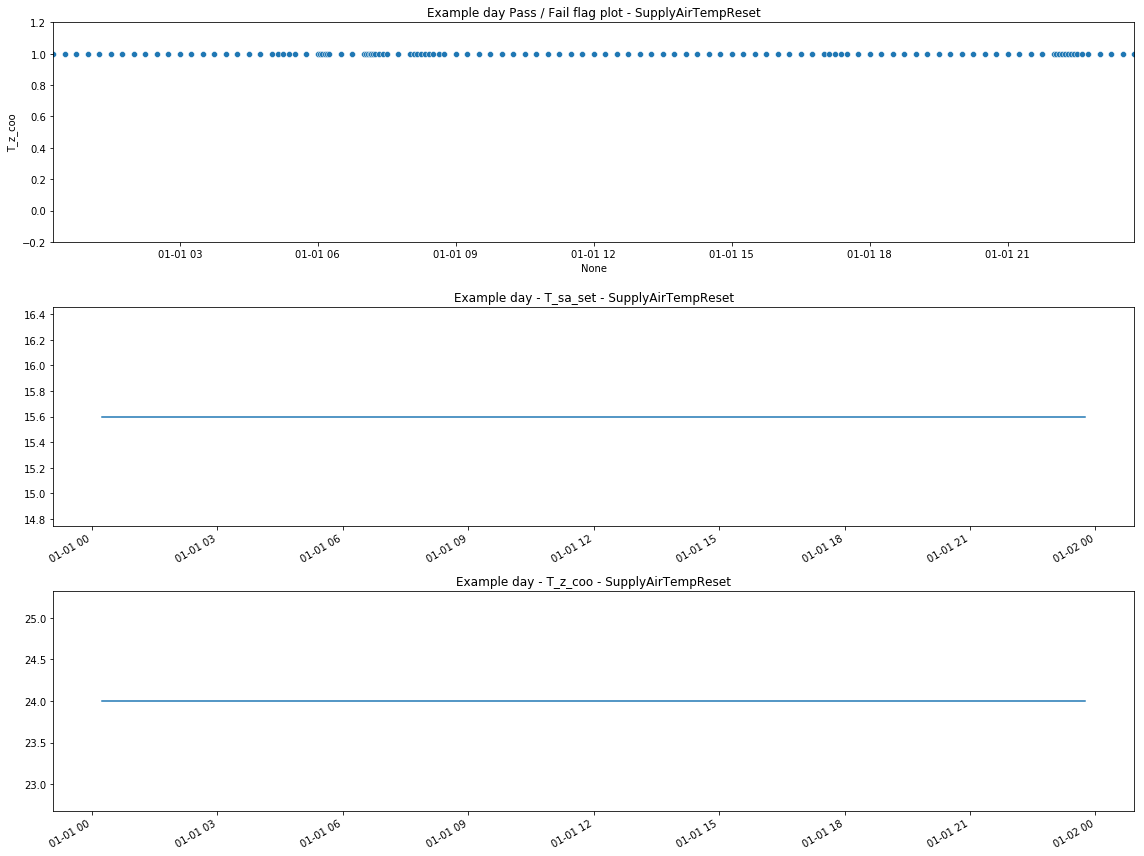

In [6]:
# Build verification items
items = assemble_verification_items(
    cases_path="../resources/tspr_cases/tspr_verification_cases.json", 
    lib_items_path="../schema/library.json"
)
item = items[0]

# Run verification
try:
    plt.rcParams['figure.figsize'] = [16, 4 * 3]
    run_libcase(item, plot_option='day-expand')
except Exception as e:
    print(e)